<a href="https://colab.research.google.com/github/fabricio-franca/Data_Science/blob/main/GS_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introdução ao Problema


O objetivo é prever o consumo de energia elétrica no Brasil com base em variáveis históricas,como mês, ano, categoria de consumo e outras.


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

1. Coleta e Tratamento dos Dados

a. Importação do Dataset
Primeiro, vamos importar o dataset do arquivo dos dados.

In [23]:
# Importando o dataset
file_path = '/content/consumo_eletrico_brasil (1).csv'
df = pd.read_csv(file_path, sep=',')

b. Filtragem dos Dados Residenciais
Filtramos os dados para considerar apenas o tipo de consumo residencial.

In [24]:
# Filtrando apenas o tipo de consumo residencial
df_residencial = df[df['tipo_consumo'] == 'Residencial']

c. Agregação das Informações dos Estados
Agregamos as informações dos estados considerando o consumo total e o número de consumidores.

In [25]:
# Agregando as informações por estado e mês
df_aggregated = df_residencial.groupby(['ano', 'mes', 'sigla_uf']).agg({
    'numero_consumidores': 'sum',
    'consumo': 'sum'
}).reset_index()

In [28]:
# Verificando a presença de valores ausentes
print(df_aggregated.isnull().sum())

ano                    0
mes                    0
sigla_uf               0
numero_consumidores    0
consumo                0
dtype: int64


In [29]:
# Garantindo que as colunas 'ano' e 'mes' são inteiros
df_aggregated['ano'] = df_aggregated['ano'].astype(int)
df_aggregated['mes'] = df_aggregated['mes'].astype(int)

In [31]:
# Renomeando as colunas 'ano' e 'mes' para 'year' e 'month' e adicionando uma coluna 'day'
df_aggregated = df_aggregated.rename(columns={'ano': 'year', 'mes': 'month'})
df_aggregated['day'] = 1  # Adiciona a coluna 'day' com o valor 1 para cada linha

# Convertendo para formato de data usando as colunas 'year', 'month', e 'day'
df_aggregated['date'] = pd.to_datetime(df_aggregated[['year', 'month', 'day']])

# Ordenando os dados por data
df_aggregated = df_aggregated.sort_values(by='date')

2. Exploração e Preparação dos Dados

**Análise de Dados**

Vamos fazer uma breve análise dos dados para entender melhor o padrão de consumo.

              year        month  numero_consumidores       consumo     day  \
count  6480.000000  6480.000000         6.480000e+03  6.480000e+03  6480.0   
mean   2013.500000     6.500000         2.343447e+06  3.736610e+05     1.0   
min    2004.000000     1.000000         6.602100e+04  1.264500e+04     1.0   
25%    2008.750000     3.750000         6.634945e+05  9.144250e+04     1.0   
50%    2013.500000     6.500000         1.156076e+06  1.809670e+05     1.0   
75%    2018.250000     9.250000         2.770015e+06  4.171208e+05     1.0   
max    2023.000000    12.000000         1.920126e+07  4.324911e+06     1.0   
std       5.766726     3.452319         3.122225e+06  5.885444e+05     0.0   

                      date  
count                 6480  
mean   2013-12-15 23:00:00  
min    2004-01-01 00:00:00  
25%    2008-12-24 06:00:00  
50%    2013-12-16 12:00:00  
75%    2018-12-08 18:00:00  
max    2023-12-01 00:00:00  
std                    NaN  


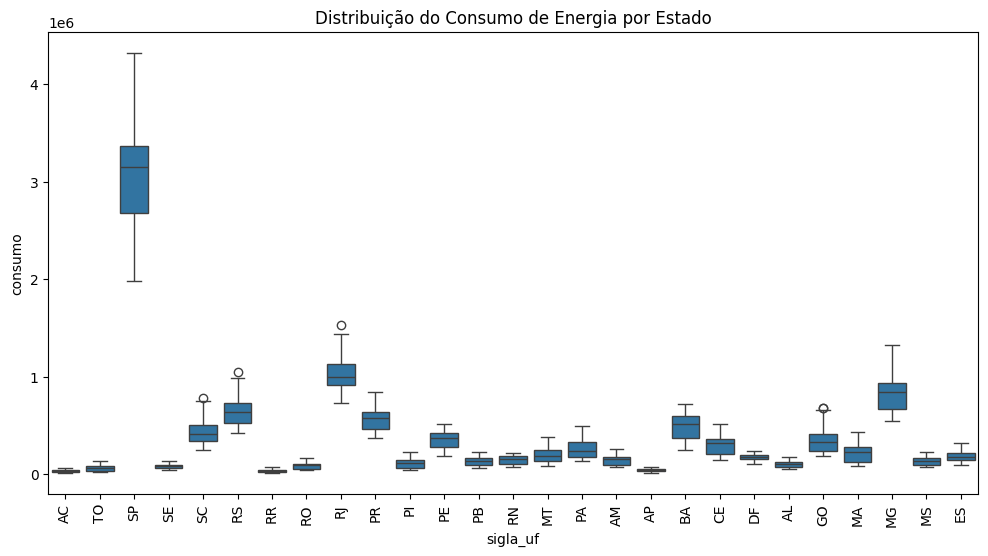

In [32]:
# Descrição estatística dos dados
print(df_aggregated.describe())

plt.figure(figsize=(12, 6))
sns.boxplot(x='sigla_uf', y='consumo', data=df_aggregated)
plt.xticks(rotation=90)
plt.title('Distribuição do Consumo de Energia por Estado')
plt.show()

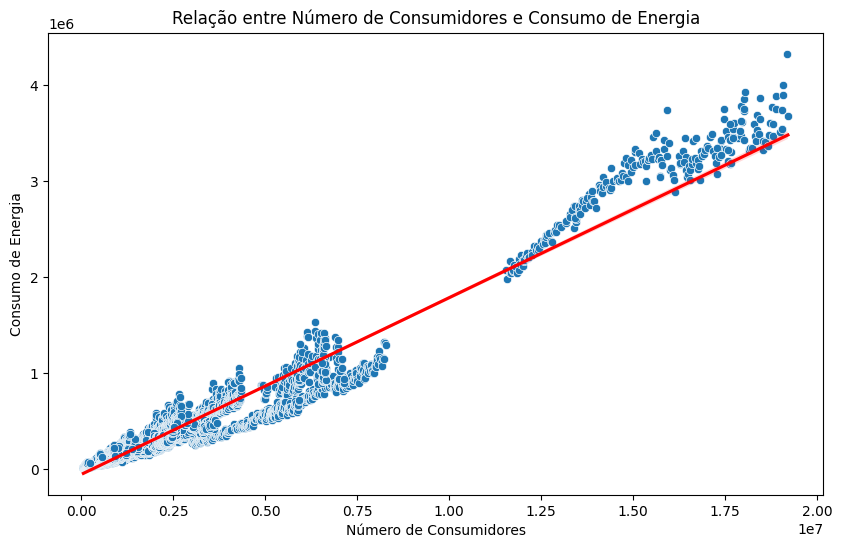

In [45]:
# Gráfico da relação entre número de consumidores e consumo
plt.figure(figsize=(10, 6))
sns.scatterplot(x='numero_consumidores', y='consumo', data=df_aggregated)
sns.regplot(x='numero_consumidores', y='consumo', data=df_aggregated, scatter=False, color='red')
plt.xlabel('Número de Consumidores')
plt.ylabel('Consumo de Energia')
plt.title('Relação entre Número de Consumidores e Consumo de Energia')
plt.show()

**Pré-processamento**

i. Divisão dos Dados

Vamos dividir o dataset em conjuntos de treino (80%) e teste (20%), mantendo a ordem das datas.

In [48]:
# Separando em treino e teste
train_size = int(len(df_aggregated) * 0.8)
train_data = df_aggregated[:train_size]
test_data = df_aggregated[train_size:]

3. Construção do Modelo

**Modelo de Regressão Linear**

Vamos criar e treinar o modelo de Regressão Linear.

In [47]:
# Selecionando as variáveis de entrada e saída
X_train = train_data[['numero_consumidores']]
y_train = train_data['consumo']
X_test = test_data[['numero_consumidores']]
y_test = test_data['consumo']

In [49]:
# Criando o modelo
model = LinearRegression()

# Treinando o modelo
model.fit(X_train, y_train)

LinearRegression()

4. Avaliação do Modelo

**Teste nos Dados de Teste e Cálculo de Erros**

Vamos avaliar o modelo usando o conjunto de teste e calcular o MSE.

In [50]:
# Previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calculando o MSE
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

MSE: 19264234492.799393


**Visualização**

Vamos plotar um gráfico comparando as previsões com os valores reais.

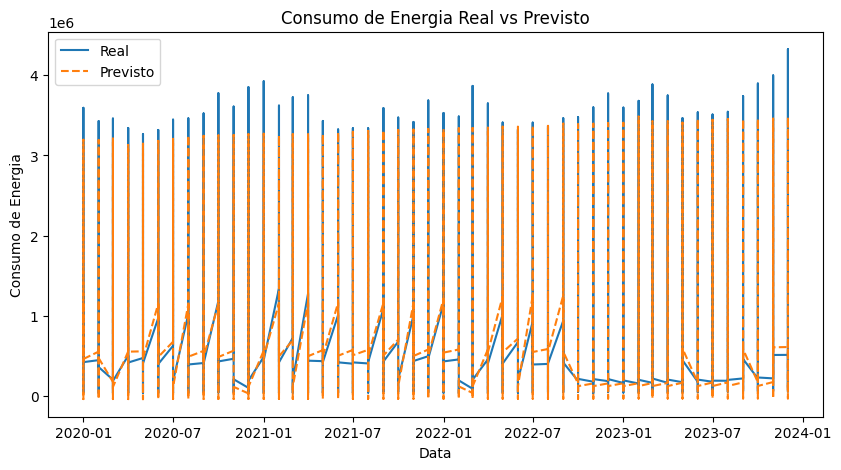

In [38]:
# Visualização
plt.figure(figsize=(10, 5))
plt.plot(test_data['date'], y_test, label='Real')
plt.plot(test_data['date'], y_pred, label='Previsto', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Consumo de Energia')
plt.title('Consumo de Energia Real vs Previsto')
plt.legend()
plt.show()

5. Previsão para os Próximos Meses

**Aplicação do Modelo**

Vamos usar o modelo treinado para fazer previsões para os próximos 12 meses.

In [40]:
# Previsões para os próximos 12 meses
future_dates = pd.date_range(start=test_data['date'].max(), periods=13, freq='ME')[1:]
future_consumers = test_data['numero_consumidores'].tail(12).values  # Assumindo que o número de consumidores se mantém constante

future_predictions = model.predict(future_consumers.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [41]:
# Criando um DataFrame com as previsões
future_df = pd.DataFrame({
    'date': future_dates,
    'consumo_previsto': future_predictions
})

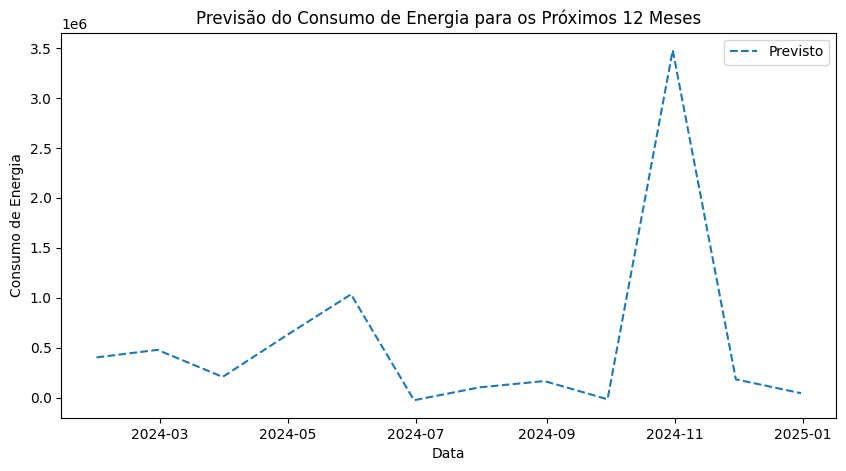

In [42]:
# Plotando as previsões
plt.figure(figsize=(10, 5))
plt.plot(future_df['date'], future_df['consumo_previsto'], label='Previsto', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Consumo de Energia')
plt.title('Previsão do Consumo de Energia para os Próximos 12 Meses')
plt.legend()
plt.show()

In [46]:
# Precisão do modelo
print(f'Precisão do modelo (MSE): {mse}')

Precisão do modelo (MSE): 19264234492.799393


# Análise dos Resultados

### A análise inicial dos dados mostrou uma variação significativa no consumo de energia entre os diferentes estados.

Observamos uma relação positiva entre o número de consumidores e o consumo de energia. À medida que o número de consumidores aumenta, o consumo de energia também tende a aumentar. O gráfico de dispersão, com uma linha de tendência, ilustra essa relação.

**Precisão do Modelo**: O modelo de Regressão Linear apresentou um Erro Médio Quadrático (MSE) de 19.264.234.492,80, indicando a precisão das previsões realizadas.

**Comparação de Previsões e Valores Reais**: O gráfico  compara as previsões do modelo com os valores reais de consumo de energia no conjunto de teste. As linhas mostram que o modelo conseguiu capturar bem a tendência geral do consumo de energia, embora existam algumas discrepâncias em determinados pontos.

**Previsão para os Próximos 12 Meses**: Utilizamos o modelo para prever o consumo de energia para os próximos 12 meses. O gráfico mostra as previsões, indicando uma tendência de picos no consumo de energia em determinados meses (mais próximos ao verão) e um pequeno aumento nos meses de inverno.

# Conclusões

**Desempenho do Modelo**: O modelo de Regressão Linear mostrou-se eficaz em prever o consumo de energia elétrica residencial com uma precisão razoável, capturando a tendência geral dos dados históricos.

**Importância das Variáveis**: O número de consumidores foi uma variável significativa para prever o consumo de energia, o que faz sentido, pois mais consumidores geralmente resultam em maior consumo.

**Padrões de Consumo**: Observamos que estados com maior número de consumidores tendem a ter um consumo de energia mais elevado. Isso é consistente com a expectativa de que um maior número de residências resulta em maior demanda por energia.

**Previsão de Aumento no Consumo**: As previsões indicam uma tendência de aumento no consumo de energia elétrica residencial nos próximos meses, o que pode ser influenciado por diversos fatores como crescimento populacional e aumento da urbanização.